In [1]:
import pandas as pd
import signatureanalyzer as sa
from typing import Union
import os
import glob
import numpy as np
from tqdm import tqdm
import sys
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../../funcs')

import plotting as pl

## Downsampling Figures
---

Robustness analysis of ARD-NMF by downsampling number of patients.


In [2]:
n_s = list()
n_k = list()

for file in tqdm(glob.glob('downsamples/**/**/nmf_output.h5')):
    n_s.append(file.split('/')[1].split("_")[1])
    n_k.append(pd.read_hdf(file,'Hraw').shape[0])

100%|██████████| 300/300 [00:01<00:00, 153.68it/s]


In [3]:
samples_df = pd.DataFrame(n_s, columns=['n'])
samples_df['k'] = n_k
samples_df = samples_df.astype(int)

In [4]:
NMF_FILE = "../signatures/061721_imputed_res_reg/nmf_output.h5"
W = pd.read_hdf(NMF_FILE,'Wraw')

In [22]:
def match_signatures(file, W, thresh=0.8):
    """Match signatures."""
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Load W_prime
    W_prime = pd.read_hdf(file,'Wraw')
    W_prime.columns = W_prime.columns + '_run'
    W_prime_ids = W_prime.columns
    W_prime = W.join(W_prime).T
    
    # Get samples per signature
    H_prime = pd.read_hdf(file, "H")
    samples_by_sig_df = pd.DataFrame(H_prime.groupby('max_id').size())
    samples_by_sig_df.columns=["n_samples"]
    samples_by_sig_df.index = ["S{}_run".format(x) for x in samples_by_sig_df.index]
        
    # Compute Cosine Simliarity
    corr = pd.DataFrame(
        cosine_similarity(W_prime), 
        index=W_prime.index, 
        columns=W_prime.index).loc[W_prime_ids, W.columns]
    
    # Matches
    max_df = pd.DataFrame(corr.idxmax(1), columns=['hit'])
    max_df['cosine'] = corr.max(1)
    max_df['match'] = max_df['cosine'] > thresh
    
    try:
        max_df['n'] = int(file.split("/")[1].split("_")[1])
        max_df['sample'] = file.split("/")[2]
    except:
        max_df['sample'] = file.split("/")[1]
    
    return max_df.sort_values('cosine', ascending=False).join(samples_by_sig_df)

def match_all_signatures(glob_path, W, **kwargs):
    """Match all signatures."""
    results_df = list()
    
    if isinstance(glob_path, str):
        for file in tqdm(glob.glob(glob_path)):
            results_df.append(match_signatures(file, W, **kwargs))
    elif isinstance(glob_path, list):
        for file in tqdm(glob_path):
            results_df.append(match_signatures(file, W, **kwargs))
    else:
        return

    results_df = pd.concat(results_df)
    
    try:
        results_df['n_samples'] = results_df['n_samples'].fillna(0)
        results_df['n_samples'] = results_df['n_samples'].astype(int)
        count_df = pd.DataFrame(results_df[results_df['match']].groupby(['hit','n']).size()).reset_index()
        return count_df.pivot(index='hit', columns='n', values=0).fillna(0).astype(int), results_df
    except:
        return results_df

def plot_pretty_box(data, x, y, ax=None, s:float = 5, order=None, figsize=(4,14), **kwargs):
    """Plot pretty box."""
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    sns.stripplot(
        x=x,
        y=y,
        data=data,
        ax=ax,
        s=s,
        #hue='n',
        order=order,
        zorder=0,
        color='grey',
        alpha=0.2,
        **kwargs
    )
    
    capprops = dict(linewidth=1, color='black')
    boxprops = dict(linewidth=1, edgecolor='black')
    
    sns.boxplot(
        x=x,
        y=y,
        data=data,
        ax=ax,
        showfliers=False,
        #showbox=False,
        #whis=0,
        capprops=capprops,
        boxprops=boxprops,
        medianprops=dict(linewidth=1, color="black"),
        whiskerprops=dict(color="black"),
        order=order,
        zorder=5,
        color='white',
    )

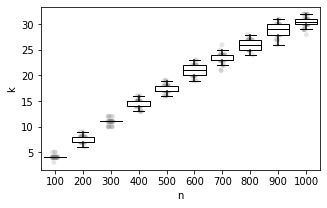

In [10]:
plot_pretty_box(samples_df, x='n', y='k', figsize=(5,3))

In [11]:
count_df, results_df = match_all_signatures('downsamples/**/**/nmf_output.h5', W, thresh=0.8)

100%|██████████| 300/300 [00:48<00:00,  6.22it/s]


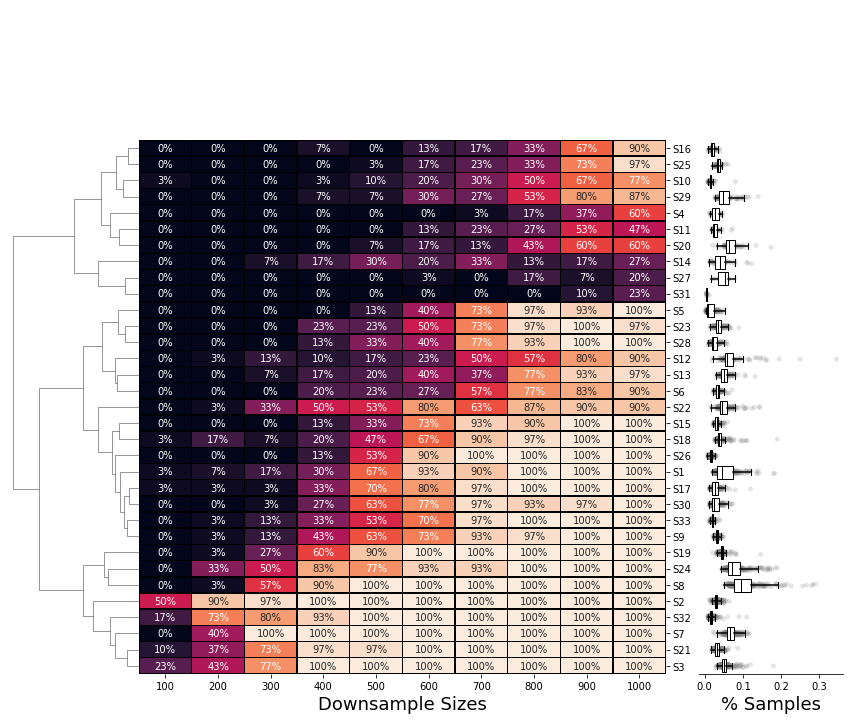

In [247]:
g = sns.clustermap(
    count_df.clip(upper=30) / 30,
    col_cluster=False,
    linewidth=0.5,
    linecolor='black',
    annot=True,
    yticklabels=True,
    fmt=".0%",
)

ax = g.ax_heatmap
ax.set_xlabel("Downsample Sizes", fontsize=18)
ax.set_ylabel("")
_y_order = [x.get_text() for x in g.ax_heatmap.get_yticklabels()]

# Remove colorbar
g.cax.set_visible(False)

# Right-Axis
ax2 = g.fig.add_axes([ax.get_position().x1*1.05, ax.get_position().y0, .2, ax.get_position().y1*.925])

plot_pretty_box(
    results_df[results_df['match']], x='percent_samples', y='hit', order=_y_order,
    ax=ax2
)

ax2.set_yticks([])
ax2.set_ylabel("")
[ax2.spines[x].set_visible(False) for x in ['top','right','left']]
ax2.set_xlabel("% Samples", fontsize=18)
plt.savefig("downsamples_clustmap_08.pdf", dpi=200, bbox_inches='tight')

100%|██████████| 300/300 [01:47<00:00,  2.78it/s]


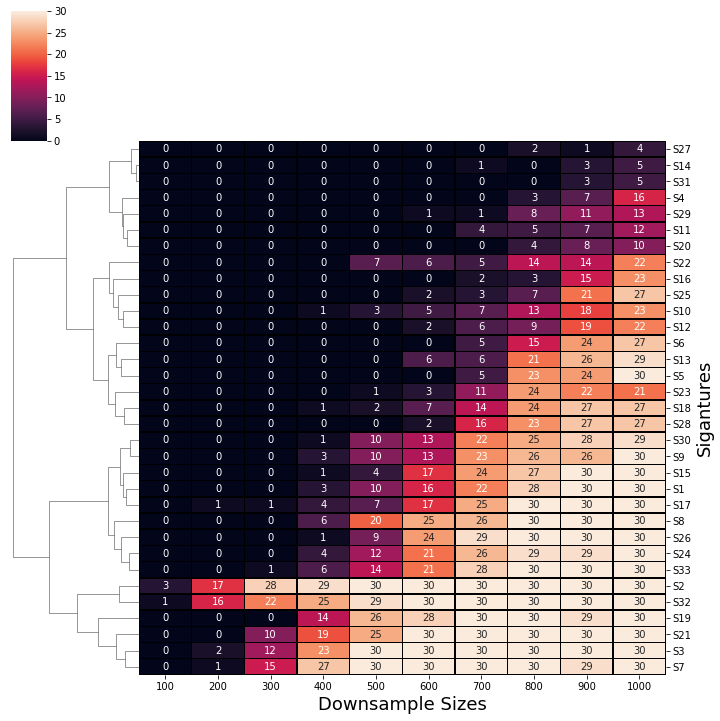

In [302]:
results_df = list()

for file in tqdm(glob.glob('downsamples/**/**/nmf_output.h5')):
    results_df.append(match_signatures(file, W, thresh=0.9))
    
results_df = pd.concat(results_df)
count_df = pd.DataFrame(results_df[results_df['match']].groupby(['hit','n']).size()).reset_index()
count_df = count_df.pivot(index='hit', columns='n', values=0).fillna(0).astype(int)

g = sns.clustermap(
    count_df,
    col_cluster=False,
    linewidth=0.5,
    linecolor='black',
    annot=True,
    yticklabels=True,
)

ax = g.ax_heatmap
ax.set_xlabel("Downsample Sizes", fontsize=18)
ax.set_ylabel("Sigantures", fontsize=18)
plt.savefig("downsamples_clustmap_09.pdf", dpi=200, bbox_inches='tight')

## Cohort Downsampling Figures
---

In [25]:
# Is MB an outlier?
samples_without_brain = [
    "BRCA_CCRCC_COAD_HNSCC_LSCC_LUAD_MEDUL_OV_PDAC_UCEC",
    "BRCA_CCRCC_COAD_GBM_HNSCC_LSCC_LUAD_OV_PDAC_UCEC",
    "BRCA_CCRCC_COAD_HNSCC_LSCC_LUAD_OV_PDAC_UCEC"
]

swob_d = {
    "BRCA_CCRCC_COAD_HNSCC_LSCC_LUAD_MEDUL_OV_PDAC_UCEC":"No GBM",
    "BRCA_CCRCC_COAD_GBM_HNSCC_LSCC_LUAD_OV_PDAC_UCEC":"No MEDUL",
    "BRCA_CCRCC_COAD_HNSCC_LSCC_LUAD_OV_PDAC_UCEC":"No BRAIN"
}

In [23]:
results_df = match_all_signatures(
    [os.path.join("downsamples_by_cohort", s, "nmf_output.h5") for s in samples_without_brain], 
    W, 
    thresh=0.8
)

100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


In [77]:
results_df['sample'] = results_df['sample'].apply(lambda x: swob_d[x])
results_df = results_df.sort_values('cosine', ascending=False).drop_duplicates(['hit','sample'])

In [78]:
hit_rank = results_df[results_df['match']][['hit','n_samples']].groupby('hit').mean().sort_values(by='n_samples').index

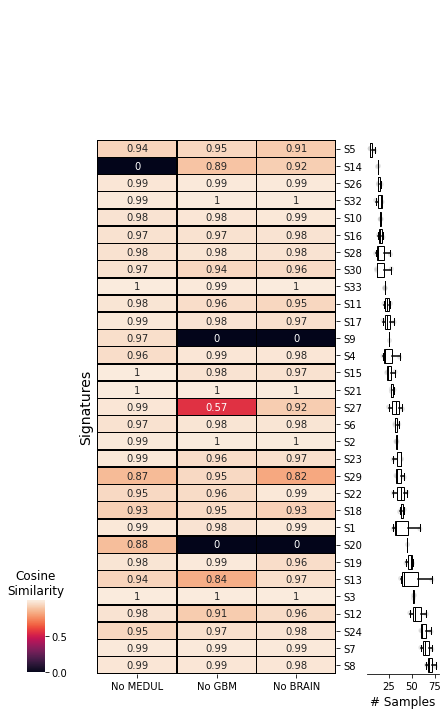

In [103]:
results_cosine_df = results_df[['hit','cosine','sample']].pivot(
    index='hit', columns='sample', values='cosine').fillna(0)

g = sns.clustermap(
    results_cosine_df.loc[hit_rank,['No MEDUL','No GBM','No BRAIN']],
    col_cluster=False,
    row_cluster=False,
    linewidth=0.5,
    linecolor='black',
    annot=True,
    yticklabels=True,
    figsize=(5,10), 
)

ax = g.ax_heatmap
ax.yaxis.set_label_position("left")
ax.set_ylabel("Signatures", fontsize=14)

ax.set_xlabel("")
_y_order = [x.get_text() for x in g.ax_heatmap.get_yticklabels()]

# Remove colorbar
#g.cax.set_visible(False)
g.cax.set_title('Cosine\nSimilarity')
g.ax_cbar.set_position((0,0.06,.05,.1))

# Right-Axis
ax2 = g.fig.add_axes([ax.get_position().x1*1.1, ax.get_position().y0, .2, ax.get_position().y1*.925])

plot_pretty_box(
    results_df[results_df['match']], x='n_samples', y='hit', order=_y_order,
    ax=ax2
)

ax2.set_yticks([])
ax2.set_ylabel("")
[ax2.spines[x].set_visible(False) for x in ['top','right','left']]
ax2.set_xlabel("# Samples", fontsize=12)

plt.savefig("cohort_downsample_brain.pdf", dpi=200, bbox_inches='tight')